# QUESTION 1

In [12]:
import numpy as np
from scipy.special import hermite
from scipy.integrate import quad ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
from scipy.integrate import quad_vec ## FUNCTIONS TO IMPLEMENT GAUSS-QUADRATURE
import matplotlib.pyplot as plt
np.random.seed(20)

### We first need to define probabilistic orthonormal hermite polynomials for standard Gaussian as well as define the corresponding scalar product and triple product

In [13]:
# Define the orthonormal probabilistic Hermite polynomial
def orthonormal_prob_hermite(n):
    return lambda x: hermite(n)(x/np.sqrt(2)) / np.sqrt(2**n * np.math.factorial(n))

# Define the integrand for scalar product
def scalar_int(i,j):
    return lambda x:orthonormal_prob_hermite(i)(x) * orthonormal_prob_hermite(j)(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi)

# Define the integrand for triple product
def triple_int(i,j,k):
    return lambda x:orthonormal_prob_hermite(i)(x) * orthonormal_prob_hermite(j)(x)* orthonormal_prob_hermite(k)(x) * np.exp(-(x**2/2))/np.sqrt(2*np.pi)

# Integrate to verify orthonormality
integral1, _ = quad(scalar_int(2,2), -np.inf, np.inf)
integral2, _ = quad(scalar_int(2,3), -np.inf, np.inf)
print(f"The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_2(x) is approximately {integral1}")
print(f"The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_3(x) is approximately {integral2}")

The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_2(x) is approximately 1.0000000000000022
The scalar product of the orthonormal probabilistic Hermite polynomials H_2(x) and H_3(x) is approximately 0.0


In [14]:
## defining kernel derivative function

def W2(x, l):
    R = np.abs(x) / l
    a = 1 / l
    mask1 = R <= 1
    mask2 = np.logical_and(R > 1, R < 2)
    result = np.zeros_like(R)
    result[mask1] = (2/3 - R[mask1]**2 + 0.5 * R[mask1]**3) * a
    result[mask2] = ((2 - R[mask2])**3) / 6 * a
    return result

def kernel(x,h):
    rr=np.abs(x)
    q=rr/h
    drx=x/(h*rr)
    alpha_=2/(3*h)
    mask1 = q < 1
    mask2 = np.logical_and(q >= 1, q < 2)
    # print(mask1.shape)
    result = np.zeros_like(q)
    result[mask1]=alpha_*(-3*q[mask1]+2.25*q[mask1]**2)*drx[mask1]
    result[mask2]=-alpha_*0.75*(2-q[mask2])**2*drx[mask2]
    return result

## coefficient alpha
def alpha(z):
    return 0.01*z+0.25

## coefficient beta
def beta(y):
    return 0.1*y+2*np.pi

In [15]:
### DEFINING CONSTANTS
T = 0.5               # Total time of integration
dt = 0.001          # Time step
N = int(T/dt)       # No of time points
a = 1               # Length of space
J = 512             # Space discretization points
q = 2               # No. of orthonarmal basis that is going to be used
max_ord=4
d = 1.2/J
x = np.linspace(0,a,J)           # Discretization points

In [16]:
def find_combinations(q, max_ord,current_sum=0, current_combination=None, all_combinations=None):
    if current_combination is None:
        current_combination = []
    if all_combinations is None:
        all_combinations = []
        
    if len(current_combination) == q:
        if current_sum < max_ord:
            all_combinations.append(current_combination[:])
        return all_combinations
    
    for i in range(max_ord - current_sum):
        current_combination.append(i)
        find_combinations(q, max_ord,current_sum + i, current_combination, all_combinations)
        current_combination.pop()

    return all_combinations

index=np.array(find_combinations(q,4))
P=index.shape[0]

In [17]:
index.shape

(10, 2)

In [18]:
def integrate(i,d=x):
    res,_=quad_vec(lambda y:orthonormal_prob_hermite(i[1])(y) * np.sin(beta(y)*d)* np.exp(-(y**2/2))/np.sqrt(2*np.pi), -10, 10)
    temp,_=quad_vec(lambda z:orthonormal_prob_hermite(i[0])(z) * alpha(z) * np.exp(-(z**2/2))/np.sqrt(2*np.pi),-10, 10)
    res = res * temp
    return res

In [19]:
P=index.shape[0]
ut = np.zeros((index.shape[0],J, N+1))
for idx,i in enumerate(index):
    ut[idx,:,0]=integrate(i)

In [20]:
## defining constants
n_particles=J    ###  number of particles
dv = 1/n_particles   ### particle volume
rho0 = 1    ##### defining some random value of intial particle density
m_i = rho0*dv    ###### mass associated with each particle
c = 10/J    ###  radius/cutoff distance 
h = 1.2/J    ### smoothing length

#### creating neigbor list for particle
n_list = [ [] for i in range(n_particles) ]
x_dis = [ [] for i in range(n_particles) ]
for i in range(n_particles):
    for j in range(n_particles):
        if(i>j):
            k=-1
        else:
            k=1
        if(i!=j):
            if(np.linalg.norm(x[i]-x[j])<c):
                n_list[i].append(j)
                x_dis[i].append(x[i]-x[j])
            elif(a+dv-np.linalg.norm(x[i]-x[j])<c):
                n_list[i].append(j)
                x_dis[i].append(k*(a+dv-np.linalg.norm(x[i]-x[j])))
n_list=np.array(n_list)
x_dis=np.array(x_dis)

In [21]:
# WE'LL FIRST DEFINE A FUNCTION THAT CALCULATES THE SPATIAL DERIVATIVE USING CENTRAL DIFFERENCE
def SPH(c,h,n_list=n_list):
    cd=np.zeros_like(c)
    for i,neighbors in enumerate(n_list):
        c_i = c[:, i][:, np.newaxis]  # Broadcasting to create the necessary shape
        c_i = np.repeat(c_i, len(neighbors), axis=1)
        c_j=c[:,neighbors]
        cd[:,i] = np.dot((c_i-c_j), -(kernel(x_dis[i], h))) * dv
    return cd

In [22]:
pre_c=np.zeros((max_ord,max_ord,max_ord))
for i in range(max_ord):
    for j in range(max_ord):
        for k in range(max_ord):
            pre_c[i,j,k],_=quad(lambda x: orthonormal_prob_hermite(i)(x)*orthonormal_prob_hermite(j)(x)* orthonormal_prob_hermite(k)(x) *np.exp(-(x**2/2))/np.sqrt(2*np.pi), -np.inf, np.inf)
            if(abs(pre_c[i,j,k])<1e-10):
                pre_c[i,j,k]=0
pre_c

array([[[1.        , 0.        , 0.        , 0.        ],
        [0.        , 1.        , 0.        , 0.        ],
        [0.        , 0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        ]],

       [[0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.        , 1.41421356, 0.        ],
        [0.        , 1.41421356, 0.        , 1.73205081],
        [0.        , 0.        , 1.73205081, 0.        ]],

       [[0.        , 0.        , 1.        , 0.        ],
        [0.        , 1.41421356, 0.        , 1.73205081],
        [1.        , 0.        , 2.82842712, 0.        ],
        [0.        , 1.73205081, 0.        , 4.24264069]],

       [[0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 1.73205081, 0.        ],
        [0.        , 1.73205081, 0.        , 4.24264069],
        [1.        , 0.        , 4.24264069, 0.        ]]])

In [23]:
def cal_c(i, pre_c, index):
    print(f"Starting {i}th iteration")
    P, q = index.shape
#     index=torch.tensor(index)
    # Initialize the output tensor c with ones
    c = np.ones((P, P))
    
    # Iterate over the range Q and perform element-wise multiplication for all combinations
    for l in range(q):
        idx_i = index[i, l]
        idx_j = index[:, l][:, np.newaxis]  # Equivalent to unsqueeze(1) in PyTorch
        idx_k = index[:, l][np.newaxis, :]  # Equivalent to unsqueeze(0) in PyTorch
        c *= pre_c[idx_i, idx_j, idx_k]
    
    return c

In [24]:
import time
import multiprocessing
from joblib import Parallel, delayed

num_cores=multiprocessing.cpu_count()


start = time.time()

c = Parallel(n_jobs=num_cores)(delayed(cal_c)(i, pre_c, index) for i in range(P))
end = time.time()

print(f"Total time taken {(end-start)/60} mins")

Total time taken 0.018633619944254557 mins


In [33]:
for n in range(1, N+1):
    ud=SPH(ut[:, :, n-1],h)
    u=ut[:, :, n-1]
    rhs = np.einsum('ijk,jm,km->im', c, u,ud)
    ut[:, :, n] = ut[:, :, n-1] - rhs*dt
    print(f"Completed the {n}^th timestep")

Completed the 1^th timestep
Completed the 2^th timestep
Completed the 3^th timestep
Completed the 4^th timestep
Completed the 5^th timestep
Completed the 6^th timestep
Completed the 7^th timestep
Completed the 8^th timestep
Completed the 9^th timestep
Completed the 10^th timestep
Completed the 11^th timestep
Completed the 12^th timestep
Completed the 13^th timestep
Completed the 14^th timestep
Completed the 15^th timestep
Completed the 16^th timestep
Completed the 17^th timestep
Completed the 18^th timestep
Completed the 19^th timestep
Completed the 20^th timestep
Completed the 21^th timestep
Completed the 22^th timestep
Completed the 23^th timestep
Completed the 24^th timestep
Completed the 25^th timestep
Completed the 26^th timestep
Completed the 27^th timestep
Completed the 28^th timestep
Completed the 29^th timestep
Completed the 30^th timestep
Completed the 31^th timestep
Completed the 32^th timestep
Completed the 33^th timestep
Completed the 34^th timestep
Completed the 35^th tim

In [34]:
u_mean=ut[0,:,:]

In [35]:
#### LET'S CALCULATE variance
def calculate_sq(ut,P):
    f=0
    for i in range(1,P):
        f+= ut[i,:,:]**2
    return  f

value=calculate_sq(ut,P)
u_std=np.sqrt(value)

## PLOTTING U_mean

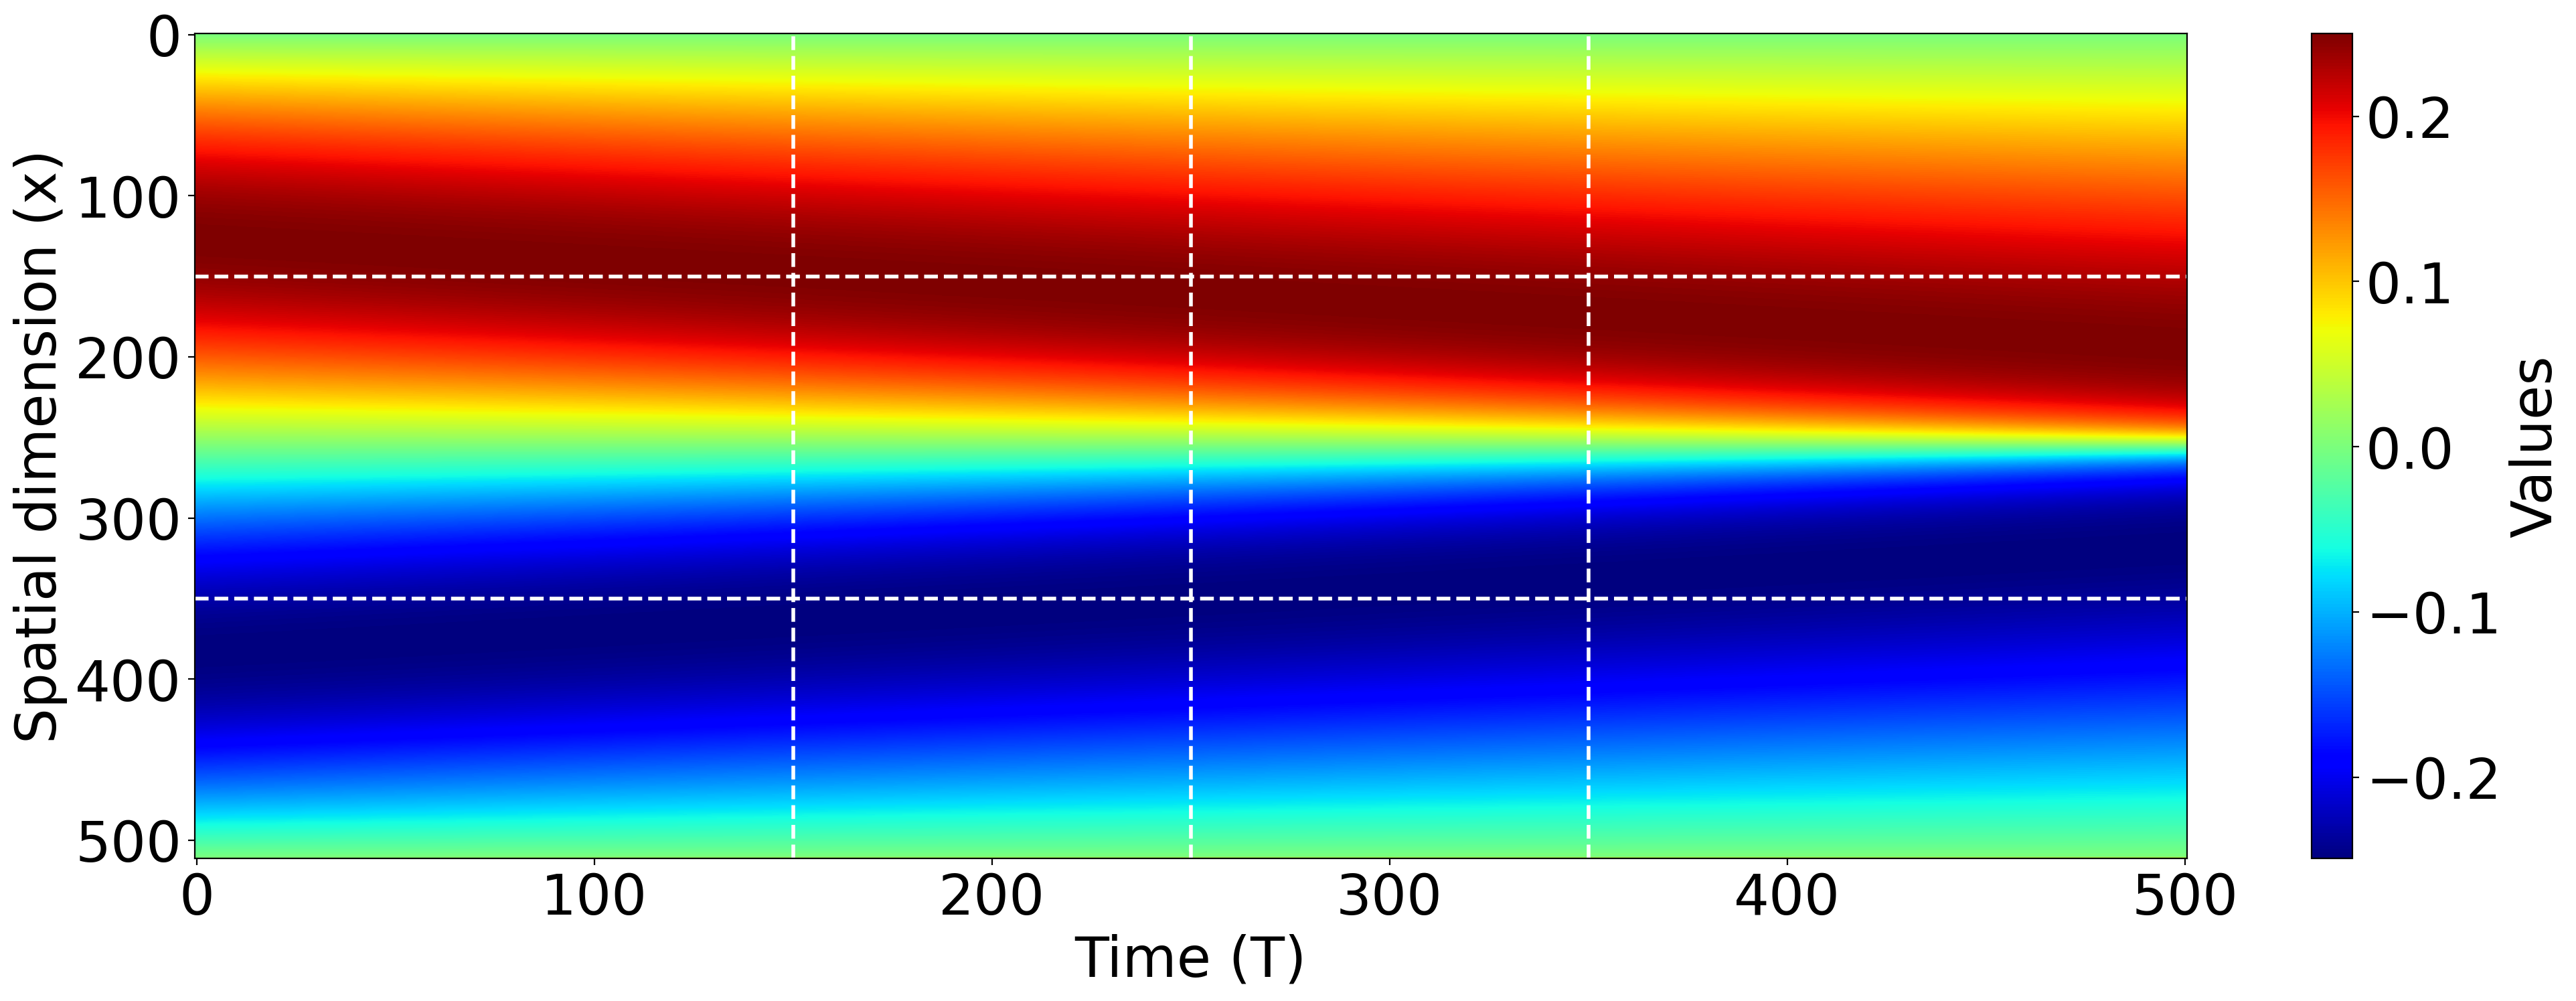

In [36]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(u_mean, aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

## PLOTTING U_var

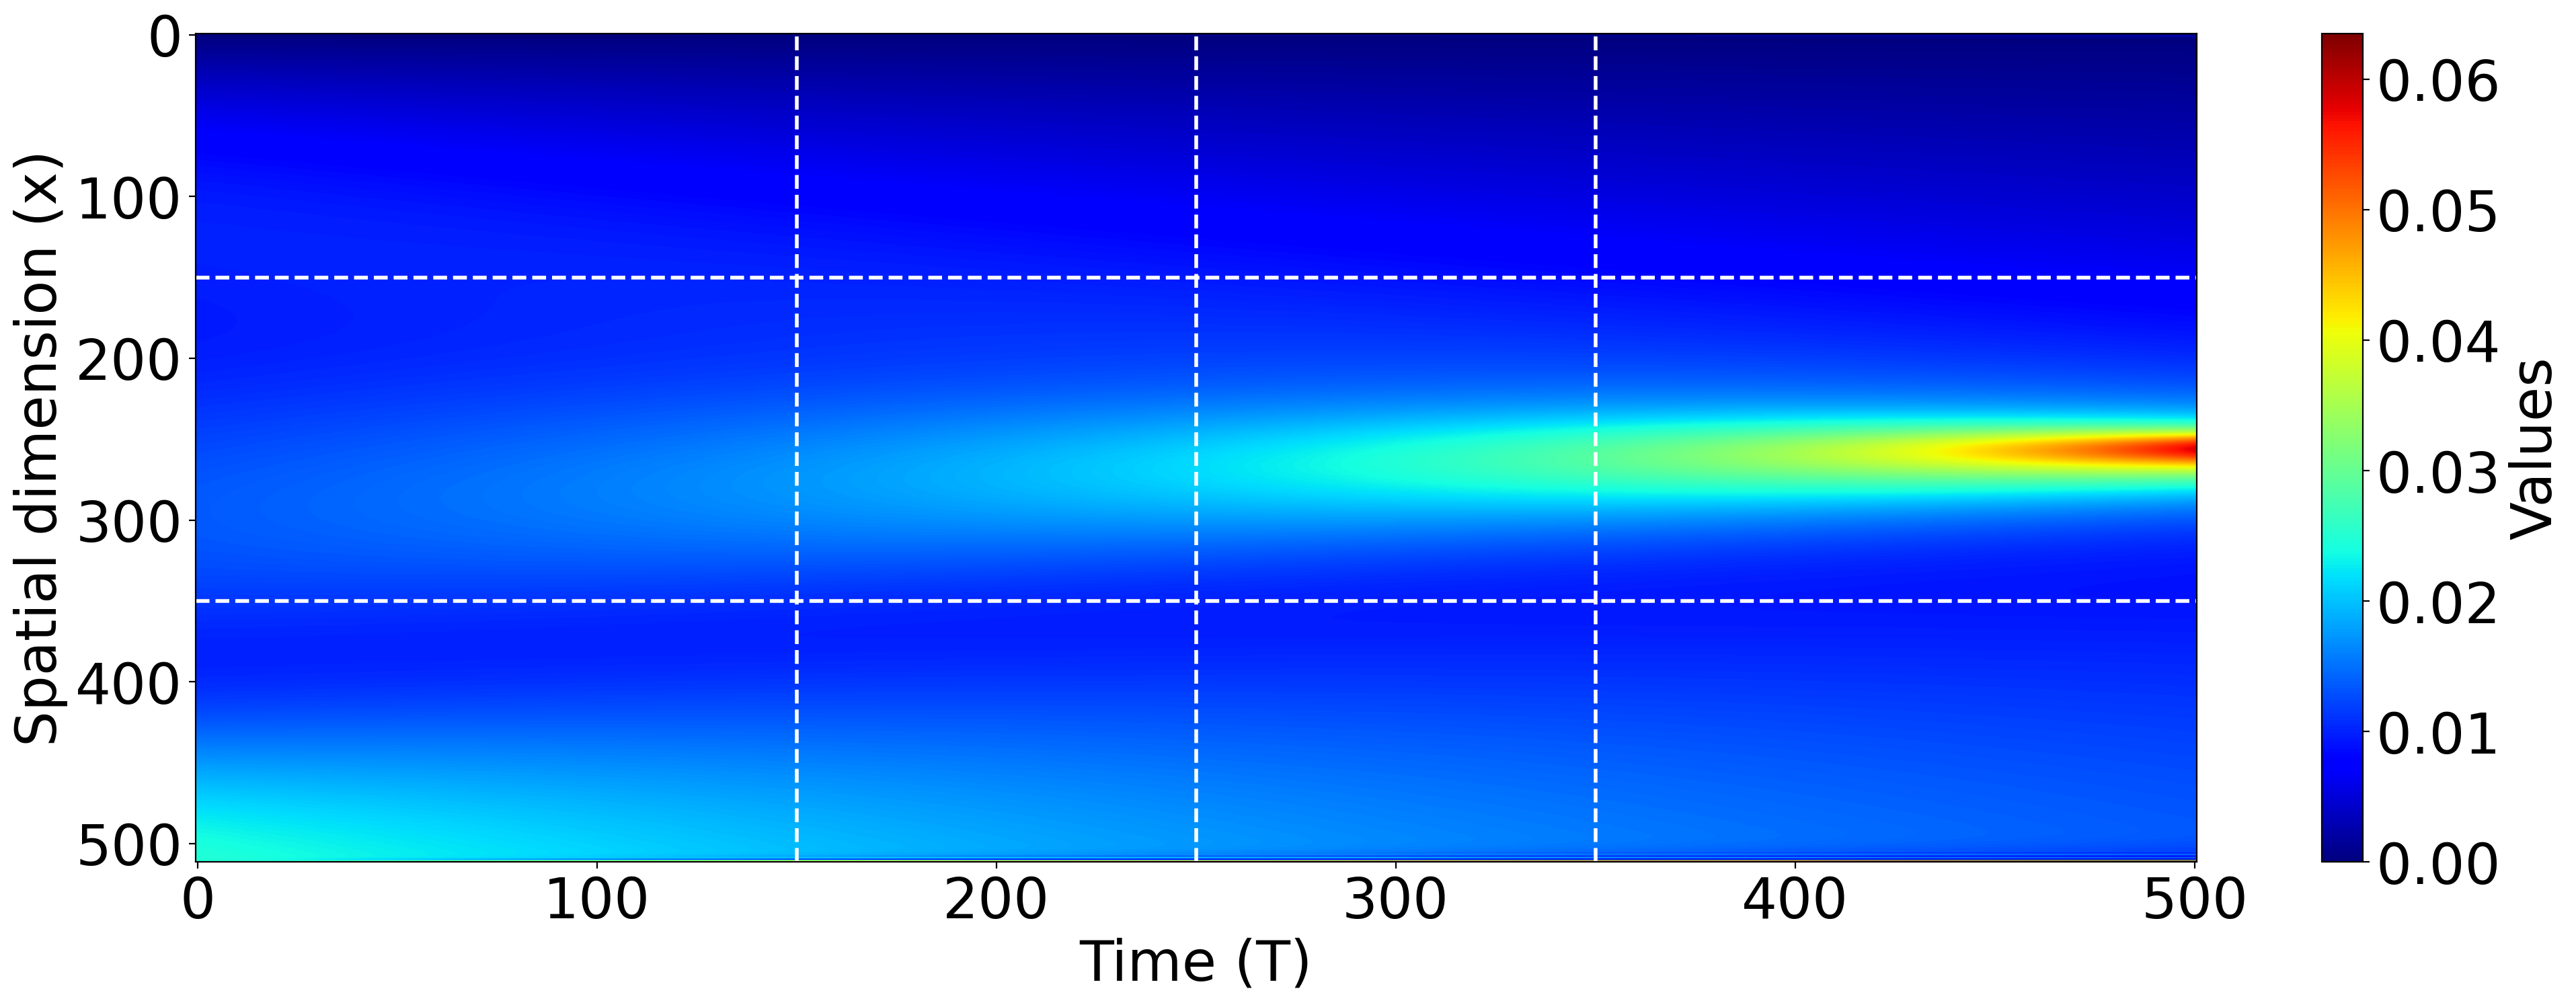

In [37]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(u_std, aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

## PLOTTING THE MCS SOLUTION

In [38]:
# WE'LL FIRST DEFINE A FUNCTION THAT CALCULATES THE SPATIAL DERIVATIVE USING CENTRAL DIFFERENCE
def SPH_mcs(c,h,n_list=n_list):
    cd=np.zeros_like(c)
    for i,neighbors in enumerate(n_list):
        c_i = c[i][np.newaxis]  # Broadcasting to create the necessary shape
        c_i = np.repeat(c_i, len(neighbors), axis=0)
        c_j=c[neighbors]
        cd[i] = np.dot((c_i-c_j), -(kernel(x_dis[i], h))) * dv
    return cd

In [39]:
import HW3_utils_data as utils

# %%

x = np.arange(0,a,a/J)           # Discretization points


from joblib import Parallel, delayed

def run_mcs(alpha, q, SPH_mcs, h, J, N, dt):
    # Sample randomness inside each worker
    a_=np.random.normal(loc=0.25,scale=0.01)
    b_=np.random.normal(loc=2*np.pi,scale=0.1)
    u0=a_*np.sin(b_*x)
    ut = np.zeros((J, N+1))
    ut[:, 0] = u0
    for n in range(1, N+1):
        ud = SPH_mcs(ut[:, n-1], h)
        u = ut[:, n-1]
        rhs = u * ud
        ut[:, n] = u - rhs * dt
        ut[0, n] = ut[J-1, n]
    return ut



In [40]:
# ==== main ====
print("STARTING MCS")
alphas = np.ones(2000)

# kick off parallel jobs; n_jobs=-1 uses all CPUs, verbose=10 prints progress
ut_mcs = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_mcs)(alpha, q, SPH_mcs, h, J, N, dt)
    for alpha in alphas
)

ut_mcs = np.array(ut_mcs)   # shape: (len(alphas), J, N+1)
print(ut_mcs.shape)
print("FINISHING MCS")

STARTING MCS


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

(2000, 512, 501)
FINISHING MCS


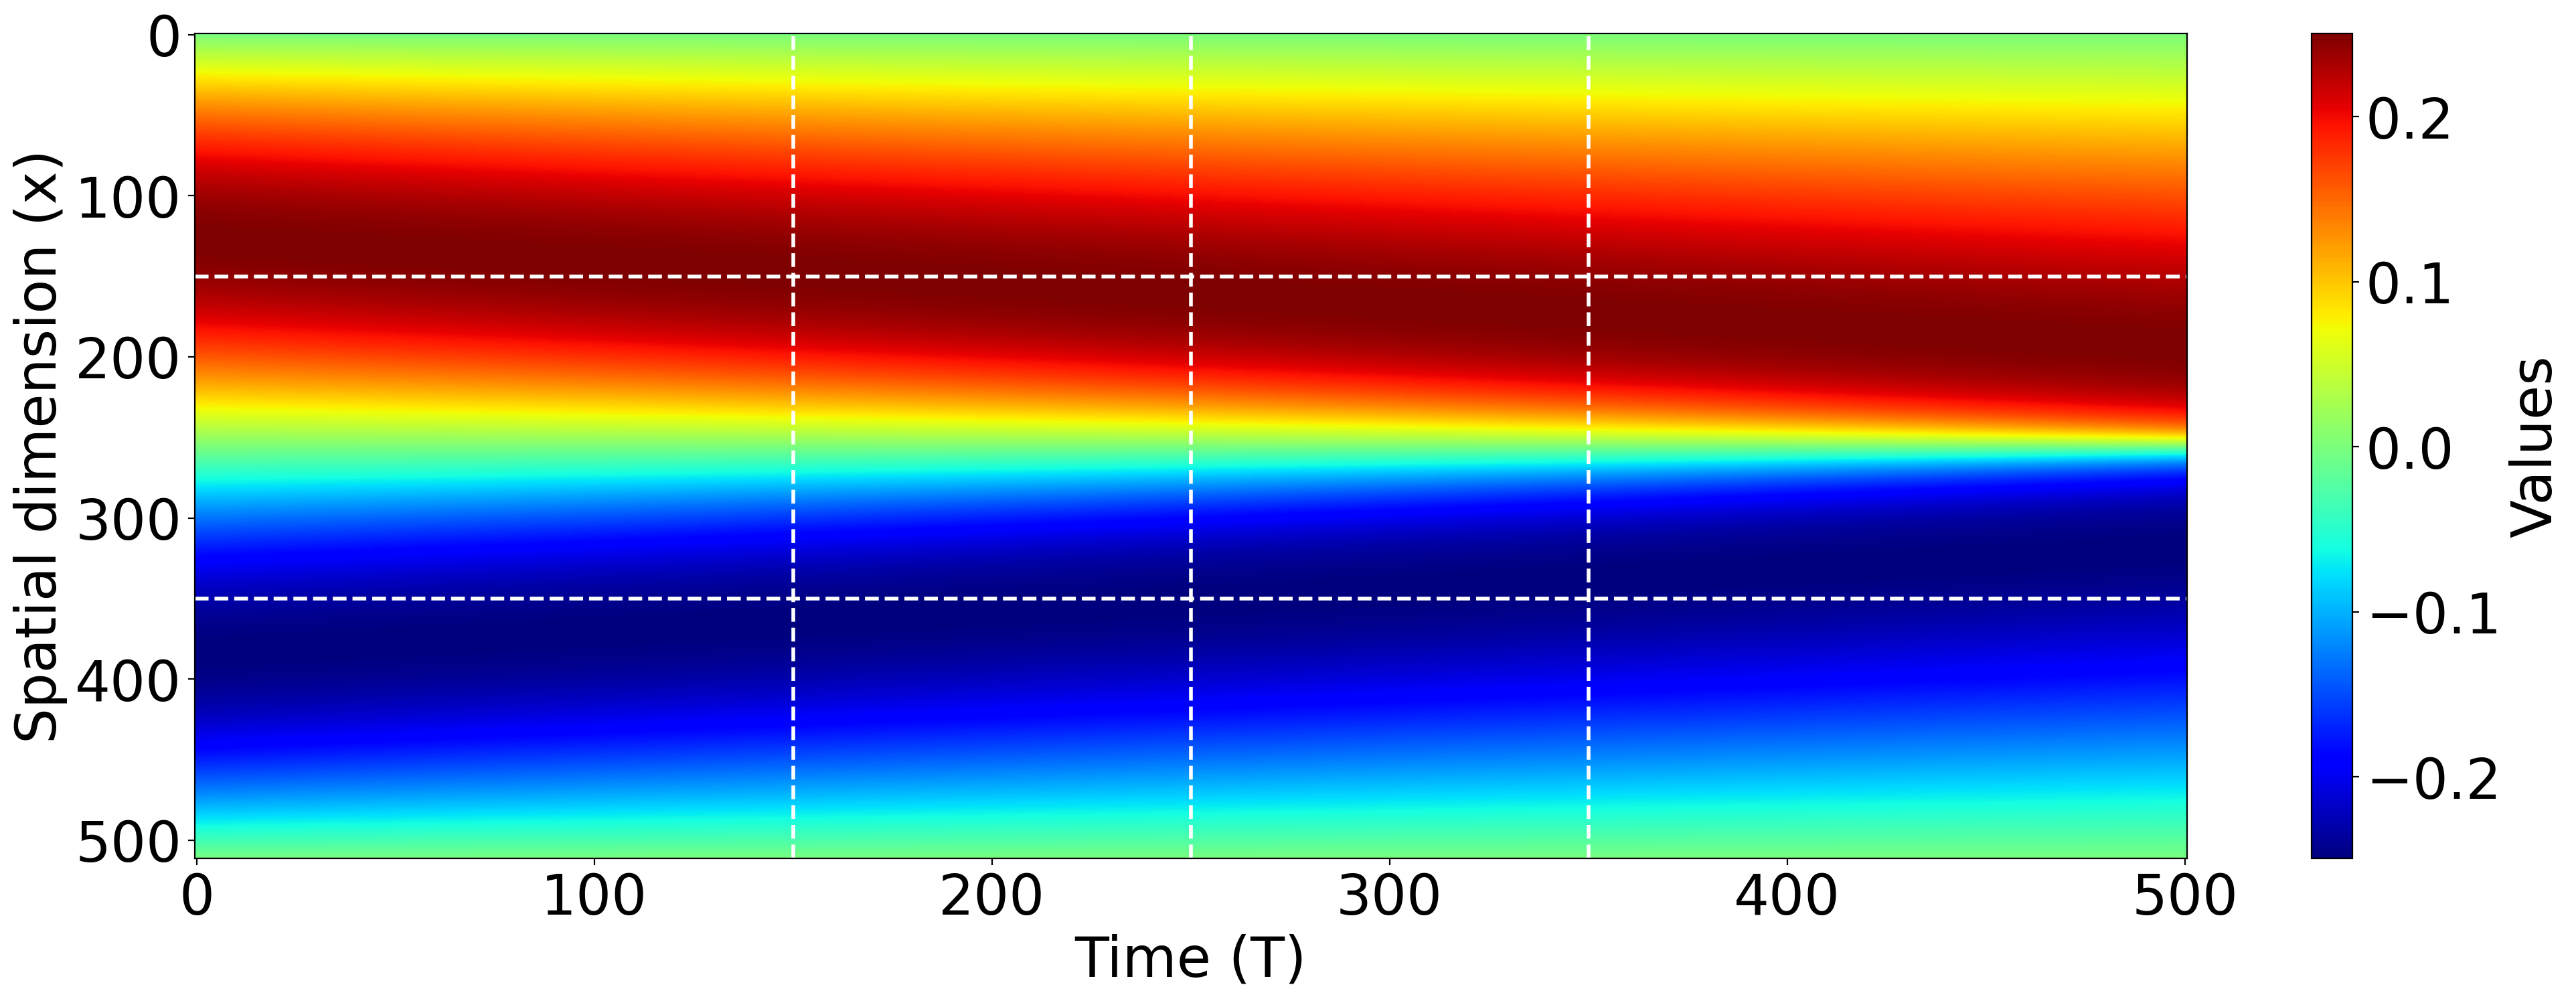

In [41]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(np.mean(ut_mcs,axis=0), aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

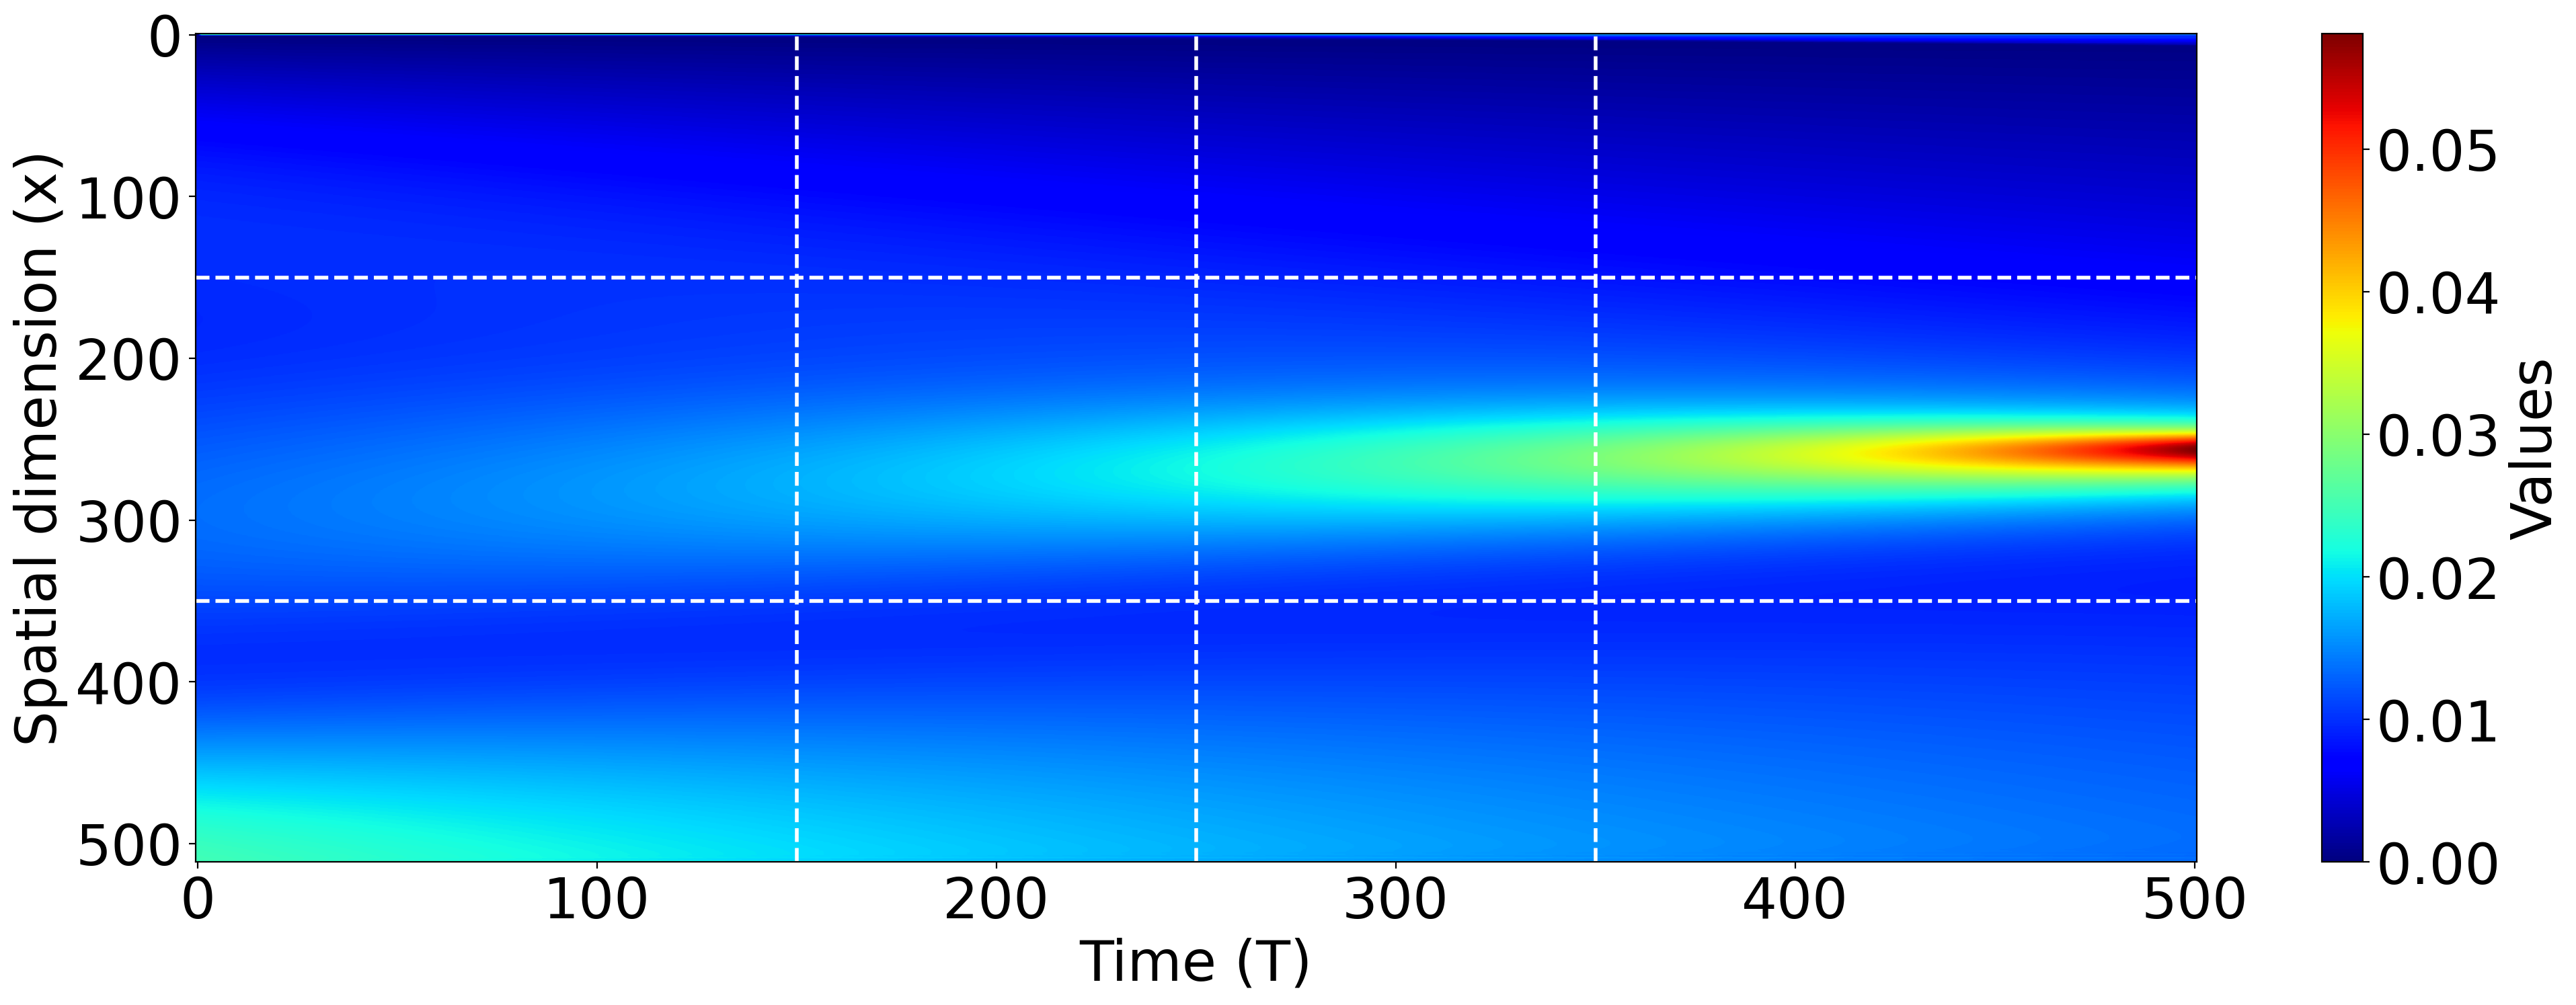

In [42]:
# set font sizes and math font
plt.rcParams['font.size'] = 30
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# create figure
fig1 = plt.figure(figsize=(24, 8), dpi=200)

# plot heatmap
heatmap = plt.imshow(np.std(ut_mcs,axis=0), aspect='auto', cmap='jet')

# add vertical lines at t = 150, 250, 350
for t in [150, 250, 350]:
    plt.axvline(x=t, color='white', linestyle='--', linewidth=2)

# add horizontal lines at x = 150, 350
for y in [150, 350]:
    plt.axhline(y=y, color='white', linestyle='--', linewidth=2)

# labels and colorbar
plt.xlabel('Time (T)')
plt.ylabel('Spatial dimension (x)')
cbar = plt.colorbar(heatmap)
cbar.set_label('Values')

plt.show()

In [43]:
mean_mcs=np.mean(ut_mcs,axis=0)
std_mcs=np.std(ut_mcs,axis=0)

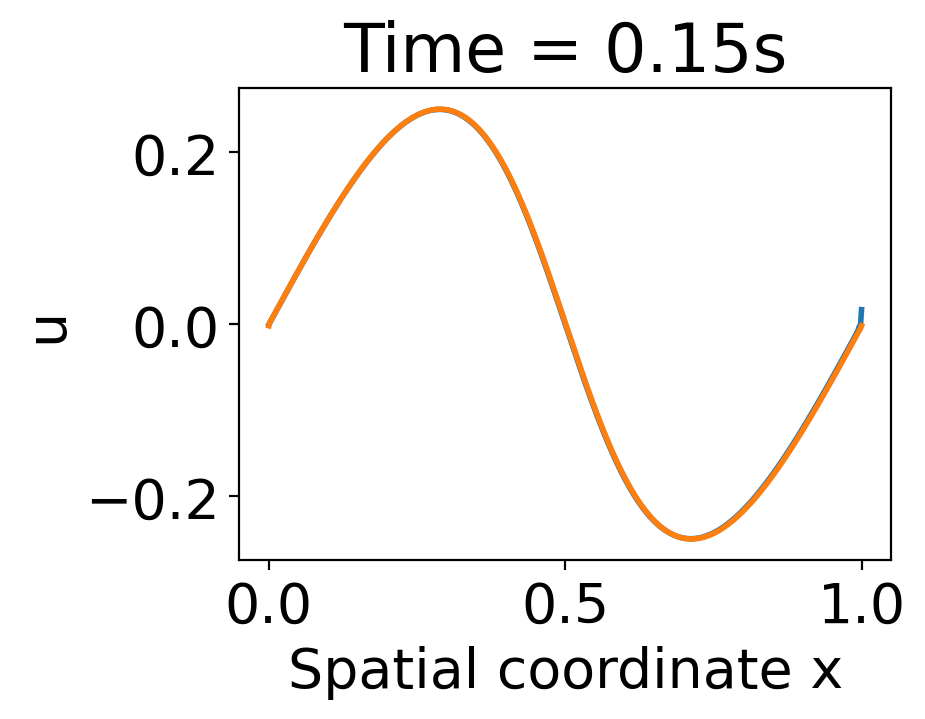

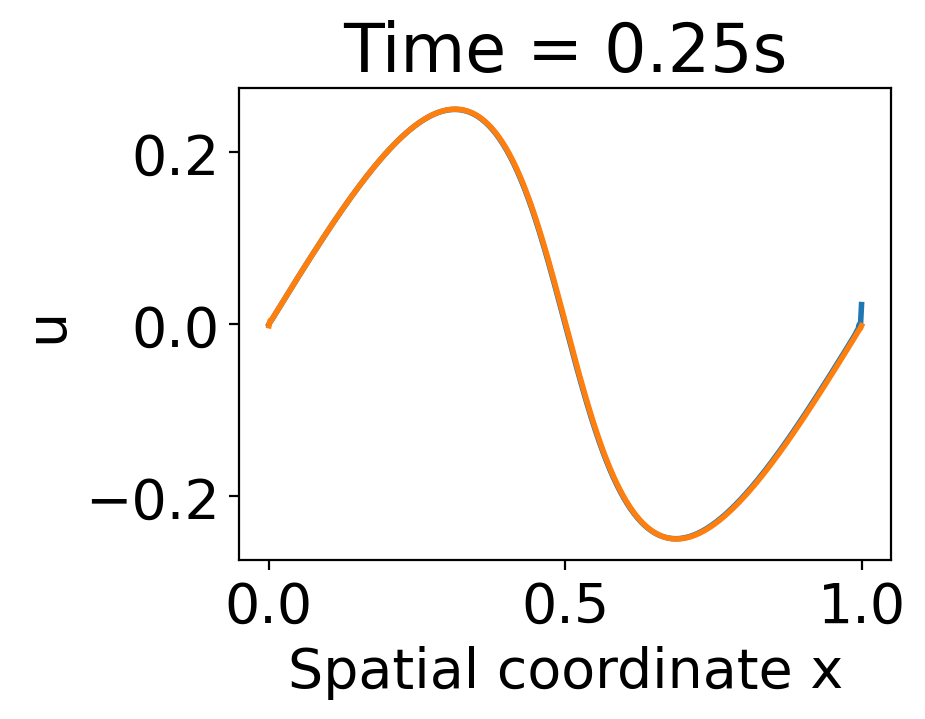

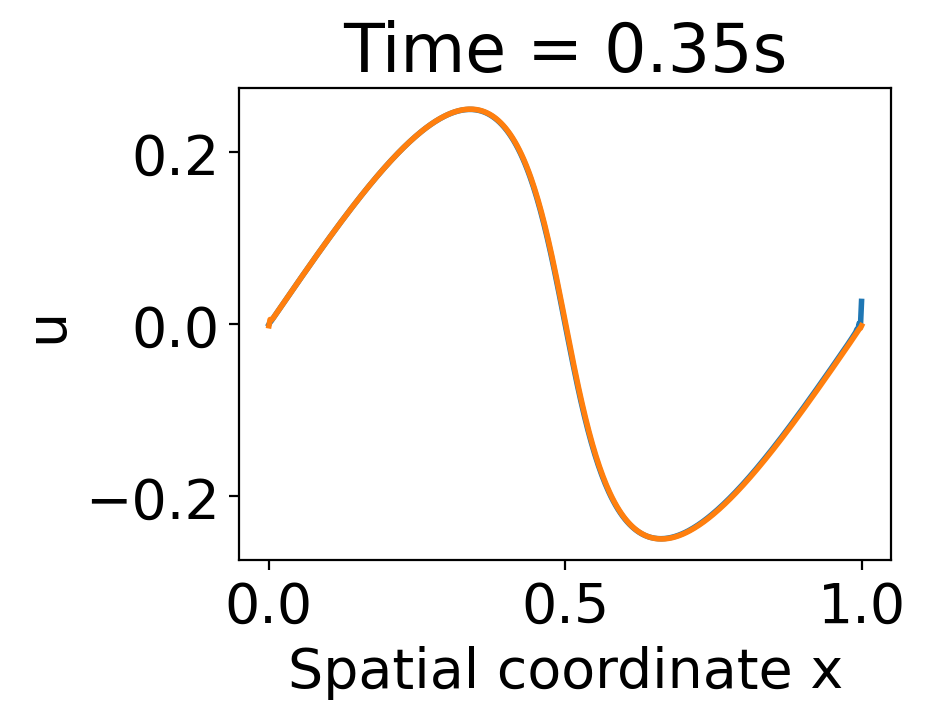

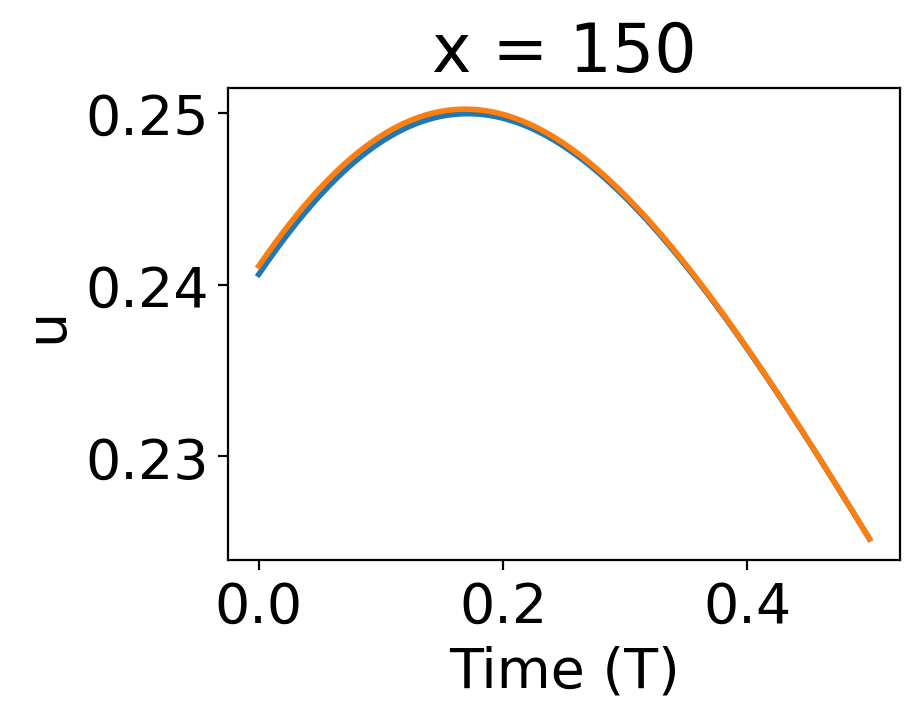

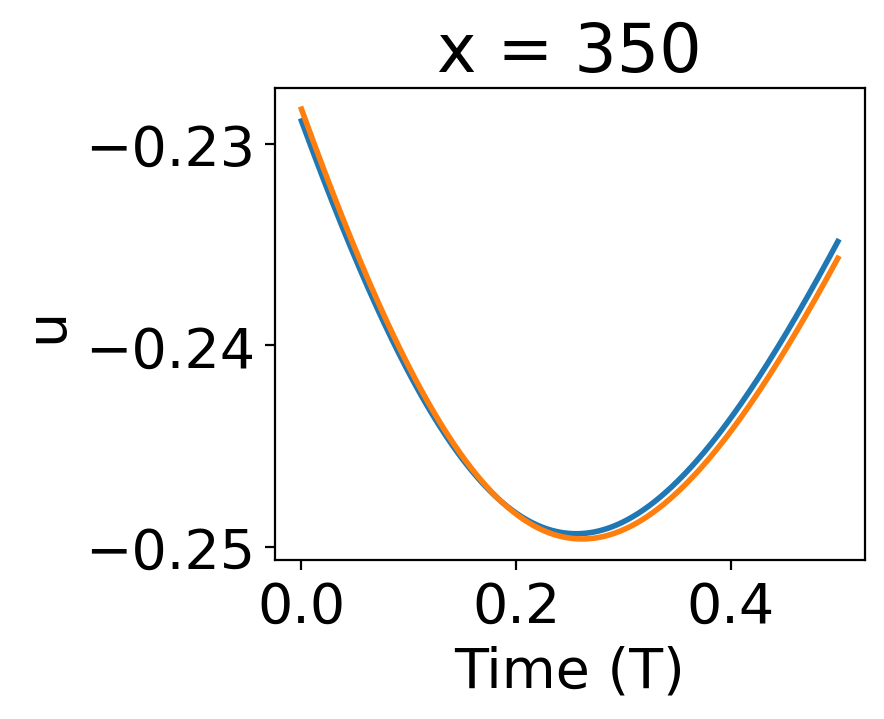

In [45]:

plt.rcParams['font.size'] = 20
# ------------------------------------------------------
# 1) Prepare your data & coordinates
# ------------------------------------------------------
# u_mean: 2D array of shape (nx, nt)
# x:    1D array (length nx) giving the spatial grid coordinates
# t:    1D array (length nt) giving the time grid coordinates

# Example placeholders (replace with your real arrays):
x = np.linspace(0, 1, u_mean.shape[0])
t = np.linspace(0, 0.5, u_mean.shape[1])

# ------------------------------------------------------
# 2) Choose five slices in time and five in space
# ------------------------------------------------------
fixed_times = [150, 250, 350]   # time-coordinates you want to hold fixed
fixed_xs    = [150, 350]   # spatial-coordinates you want to hold fixed

# find the nearest indices in your grid
time_inds = [np.abs(ti) for ti in fixed_times]
x_inds    = [np.abs(xi) for xi in fixed_xs]

# ------------------------------------------------------
# 3) Plot u(x) at each fixed time
# ------------------------------------------------------
for ti, tval in zip(time_inds, fixed_times):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(x, u_mean[:, ti], linewidth=2)
    plt.plot(x, mean_mcs[:, ti], linewidth=2)
    plt.title(f'Time = {tval/1000}s')
    plt.xlabel('Spatial coordinate x')
    plt.ylabel('u')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------
# 4) Plot u(t) at each fixed spatial location
# ------------------------------------------------------
i=0
for xi, xval in zip(x_inds, fixed_xs):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(t, u_mean[xi, :], linewidth=2)
    plt.plot(t, mean_mcs[xi, :], linewidth=2)
    plt.title(f'x = {xval}')
    plt.xlabel('Time (T)')
    plt.ylabel('u')
    # if(i==0):
    #     plt.ylim(0.002,0.018)
    # else:
    #     plt.ylim(-0.012,-0.007)
        
    i+=1
    plt.tight_layout()
    plt.show()

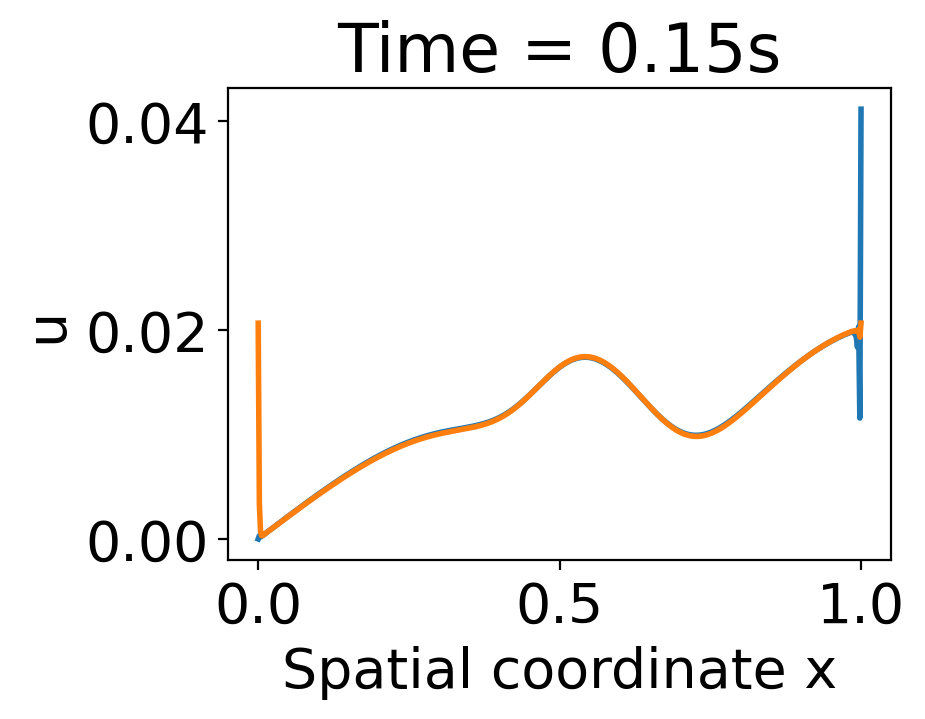

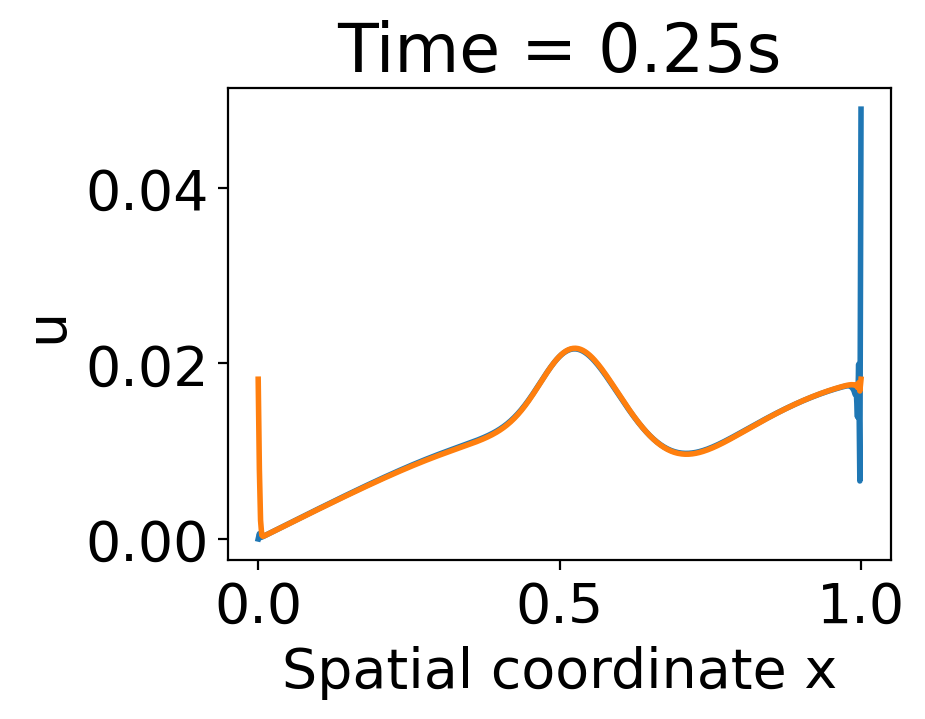

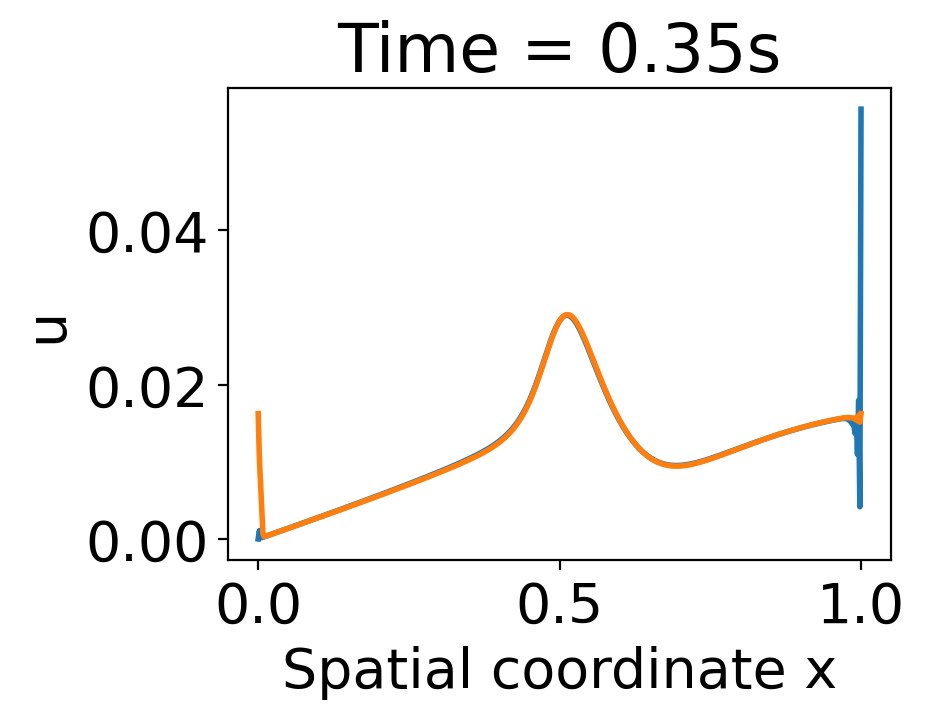

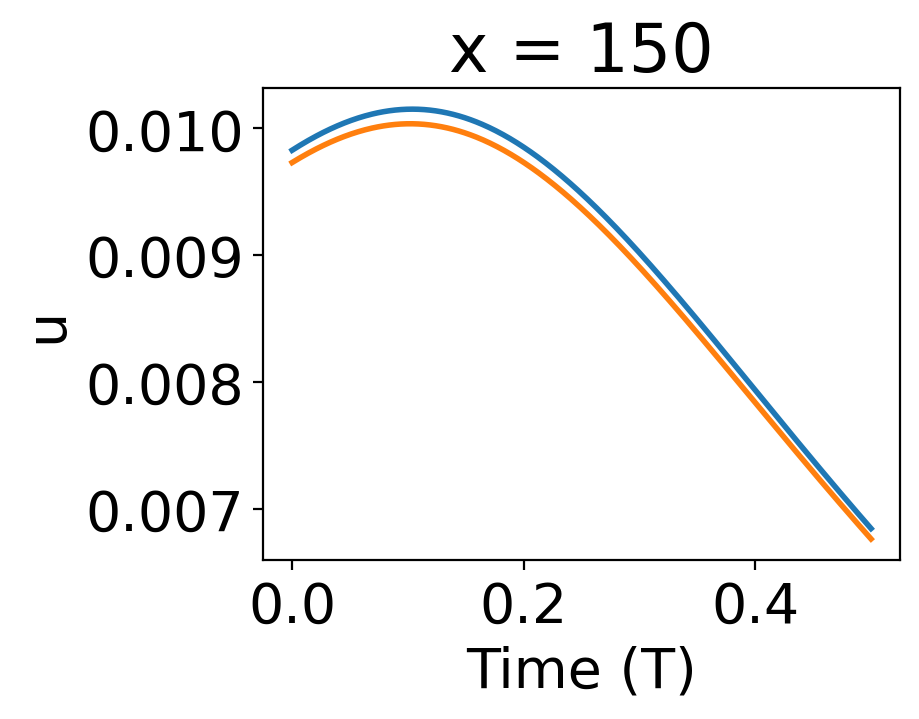

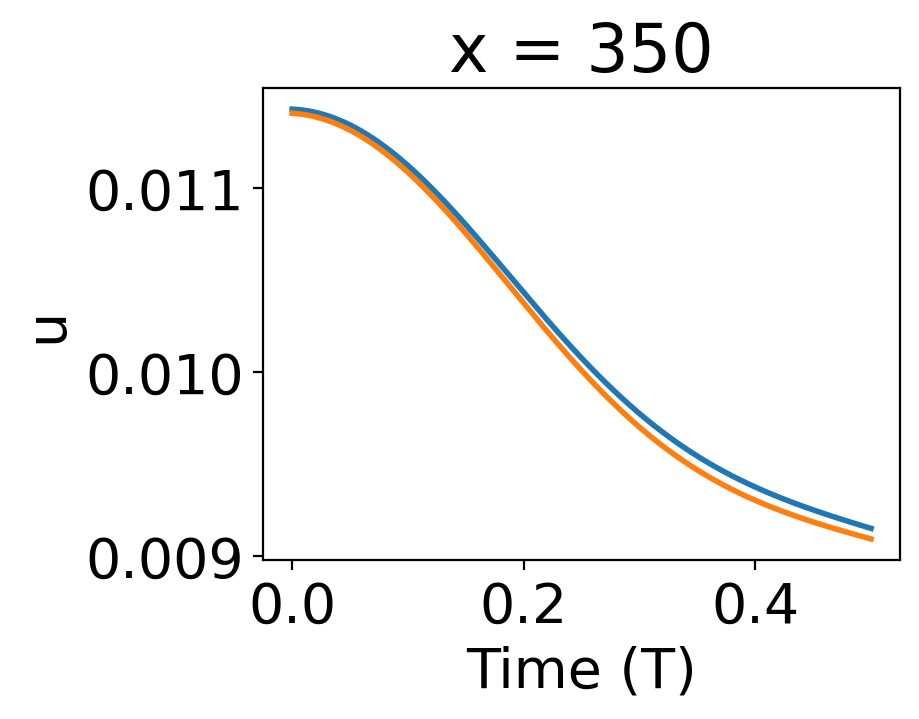

In [47]:
plt.rcParams['font.size'] = 20
# ------------------------------------------------------
# 1) Prepare your data & coordinates
# ------------------------------------------------------
# u_mean: 2D array of shape (nx, nt)
# x:    1D array (length nx) giving the spatial grid coordinates
# t:    1D array (length nt) giving the time grid coordinates

# Example placeholders (replace with your real arrays):
x = np.linspace(0, 1, u_mean.shape[0])
t = np.linspace(0, 0.5, u_mean.shape[1])

# ------------------------------------------------------
# 2) Choose five slices in time and five in space
# ------------------------------------------------------
fixed_times = [150, 250, 350]   # time-coordinates you want to hold fixed
fixed_xs    = [150, 350]   # spatial-coordinates you want to hold fixed

# find the nearest indices in your grid
time_inds = [np.abs(ti) for ti in fixed_times]
x_inds    = [np.abs(xi) for xi in fixed_xs]

# ------------------------------------------------------
# 3) Plot u(x) at each fixed time
# ------------------------------------------------------
for ti, tval in zip(time_inds, fixed_times):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(x, u_std[:, ti], linewidth=2)
    plt.plot(x, std_mcs[:, ti], linewidth=2)
    plt.title(f'Time = {tval/1000}s')
    plt.xlabel('Spatial coordinate x')
    plt.ylabel('u')
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------
# 4) Plot u(t) at each fixed spatial location
# ------------------------------------------------------
for xi, xval in zip(x_inds, fixed_xs):
    plt.figure(figsize=(5, 4), dpi=200)
    plt.plot(t, u_std[xi, :], linewidth=2)
    plt.plot(t, std_mcs[xi, :], linewidth=2)
    plt.title(f'x = {xval}')
    plt.xlabel('Time (T)')
    plt.ylabel('u')
    # plt.ylim(0.025, 0.035)
    plt.tight_layout()
    plt.show()